In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

> HELLO FELLOW KAGGLERS ! I DID AN EDA ON FORMULA 1 ... TRIED MY VERY BEST... UPVOTE IT IF U LIKE MY ANALYSIS ... THANKS A BUNCH

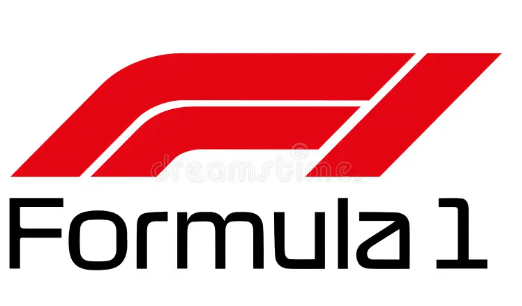

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import datetime 

**READ THE NECESSARY CSV FILES ACCORDING TO YOUR NEED**

In [ ]:
circuits = pd.read_csv('https://raw.githubusercontent.com/AkhilRD/F1-Explorative-Analysis/main/circuits.csv')
laptimes = pd.read_csv('https://raw.githubusercontent.com/AkhilRD/F1-Explorative-Analysis/main/lap_times.csv')
pitstops = pd.read_csv('https://raw.githubusercontent.com/AkhilRD/F1-Explorative-Analysis/main/pit_stops.csv')
seasons = pd.read_csv('https://raw.githubusercontent.com/AkhilRD/F1-Explorative-Analysis/main/seasons.csv',parse_dates=['year'])
status = pd.read_csv('https://raw.githubusercontent.com/AkhilRD/F1-Explorative-Analysis/main/status.csv')

In [ ]:
constructor_standings = pd.read_csv('https://raw.githubusercontent.com/AkhilRD/F1-Explorative-Analysis/main/constructor_standings.csv')
constructors = pd.read_csv('https://raw.githubusercontent.com/AkhilRD/F1-Explorative-Analysis/main/constructors.csv')
driver_standings = pd.read_csv('https://raw.githubusercontent.com/AkhilRD/F1-Explorative-Analysis/main/driver_standings.csv')
drivers = pd.read_csv('https://raw.githubusercontent.com/AkhilRD/F1-Explorative-Analysis/main/drivers.csv')

In [ ]:
races = pd.read_csv('https://raw.githubusercontent.com/AkhilRD/F1-Explorative-Analysis/main/races.csv',parse_dates=['year'])
constructor_results = pd.read_csv('https://raw.githubusercontent.com/AkhilRD/F1-Explorative-Analysis/main/constructor_results.csv')
results = pd.read_csv('https://raw.githubusercontent.com/AkhilRD/F1-Explorative-Analysis/main/results.csv')
qualifying = pd.read_csv('https://raw.githubusercontent.com/AkhilRD/F1-Explorative-Analysis/main/qualifying.csv')

In [ ]:
driver_standings.head()

**#merging the constructors dataframe with race results**

In [ ]:
team = constructors.merge(results,on='constructorId',how = 'left')

**#extracting the columns needed and grouping it by constructor name, extracting the total races entered**

In [ ]:
best = team[['name','points','raceId']]
best = best.groupby('name')['raceId'].nunique().sort_values(ascending=False).reset_index(name = 'races')
best = best[best['races'] >= 100]
best.head() 

In [ ]:
func = lambda x: x.points.sum()/x.raceId.nunique()
data = team[team['name'].isin(best.name)].groupby('name').apply(func).sort_values(ascending=False).reset_index(name = 'points_per_race')
data.head(10)

In [ ]:
#plotting the results

fig = go.Figure(
    data=[go.Bar(x = data.name, y=data['points_per_race'])],
    layout_title_text="Constructor's Points per Race"
    
)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.update_traces(textfont_size=20,
                  marker=dict(line=dict(color='purple', width=2)))
fig.show()

**#calculating historic overall points of top 10 constructors**

In [ ]:
historic_points = team.groupby('name').agg({'points':'sum'}).sort_values('points',ascending=False).reset_index().head(10)
historic_points

In [ ]:
#plotting a bar chart

fig = go.Figure(
    data=[go.Bar(x = historic_points.name, y=historic_points['points'])],
    layout_title_text="Constructor's Historic Points"
)
fig.update_traces(textfont_size=20,
                  marker=dict(line=dict(color='red', width=2)))
fig.show()

**#merging circuits, races, results and race status dataframes**

In [ ]:
df = circuits.merge(races,how='left',left_on = 'circuitid',right_on = 'circuitId')
df2 = df.merge(results,how='left',on='raceId')
status_df = df2.merge(status,how='inner',left_on = 'statusId',right_on= 'statusid')

In [ ]:
status_df.drop(['name_y','url_y','url_x','time_y'],axis=1,inplace=True)
status_df.rename(columns={'name_x':'name','time_x':'time'},inplace=True)

**#including rows with issues correlated with thin air in higher altitudes, setting the year to last 7 to include Mexico GP**

In [ ]:
altitude = status_df[status_df['status'].isin(['Transmission','Engine','Overheating'])]
altitude = altitude[altitude['year'] >= pd.to_datetime('2015-01-01')]
altitude.head()

**Grouping by track name, altitude and remaining columns**

In [ ]:
circuit_altitudes = altitude.groupby(['name','alt'])['status'].count().sort_values(ascending = False).reset_index().head(10)
circuit_altitudes.rename(columns={'status':'engine & transmission failures'},inplace=True)
circuit_altitudes

**#plotting a bubble chart: bigger the size of the bubble, higher the altitude**

In [ ]:
df = circuit_altitudes

fig = px.scatter(df, x="alt", y="engine & transmission failures",
         size="alt", color="name",
                  log_x=True, size_max= 90)
fig.update_traces(textfont_size=20,
                  marker=dict(line=dict(color='#000000', width=2)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

**# grouping by nationality, counting the driver and plotting a pie chart**

In [ ]:
driver_nationality = drivers.groupby('nationality')['nationality'].count().sort_values(ascending = False).reset_index(name = 'number of drivers')
fig = go.Figure(data=[go.Pie(labels=driver_nationality.nationality.head(10), values=driver_nationality['number of drivers'])])
fig.update_traces(textfont_size=20,
                  marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(
    title="Historical Driver Nationality Distribution since 1950")
fig.show()

**#merging driver data, their standings and race data**

In [ ]:
driver_position = drivers.merge(driver_standings,left_on='driverid',right_on='driverId',how = 'left')
driver_position = driver_position.merge(races,on = 'raceId',how = 'left')

**Filtering the dataset to include only where the position is 1 and grouping by name, year and extracting the max wins**

In [ ]:
positions = driver_position[driver_position['position'] == 1].groupby(
    ['surname','year'])['wins'].max().sort_values(ascending=False).reset_index(name = 'Wins')
positions.head(20)
positions.year = positions.year.dt.year
positions.rename(columns={'surname':'name'},inplace=True)
positions.Wins = positions.Wins.astype('int64')

positions.head(20)

In [ ]:
fig = px.scatter(positions.head(30), x="year", y="Wins", color="name",
                 title="Most wins by a driver in a single season",size = 'Wins')
fig.update_traces(textfont_size=20,
                  marker=dict(line=dict(color='#000000', width=2)))
fig.update_xaxes(showgrid=False)
fig.show()

**Most competitive seasons by points difference**

In [ ]:
competition = driver_position[driver_position['year'].dt.year == 1991
               ].groupby(['surname','year']).points.max().sort_values(ascending = False).reset_index().head(5)
competition.year = competition.year.dt.year
competition.iloc[0:2,0] 

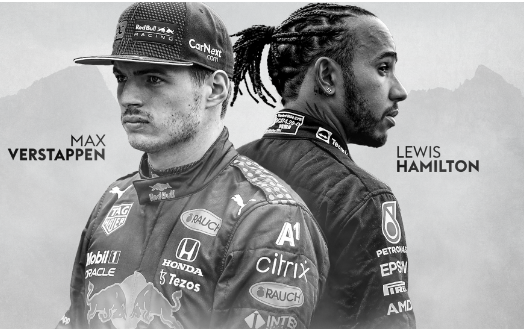

In [ ]:
def rivalry(x):
    competition = driver_position[driver_position['year'].dt.year == x
               ].groupby(['surname','year']).points.max().sort_values(ascending = False).reset_index().head(5)
    competition.year = competition.year.dt.year    
    
    h = driver_position.merge(circuits,left_on='circuitId',right_on='circuitid',how = 'left')
    h.rename(columns={'name_y':'circuit_name'},inplace=True)
    viz = h.loc[:,['date','year','circuit_name','surname','points','wins']]

    viz.dropna(inplace = True)

    viz.points = viz.points.astype('int64')
    viz.wins = viz.wins.astype('int64')
    viz.year = viz.year.dt.year
    viz.date = pd.to_datetime(viz.date)
    
    top_five = viz[viz.loc[:,'year'] == x]
    top_five = top_five.groupby(['surname'])[['points','wins']].max().sort_values('points',ascending = False).head(6).reset_index()
    
    duo = competition.iloc[0:2]
    if competition.iloc[0,2] - competition.iloc[1,2] <= 10:
        print('\033[1m' + 'BIGGEST RIVALARY IN THE MAKING!')
    elif competition.iloc[0,2] - competition.iloc[1,2] <= 20:
        print('\033[1m' + 'Spicy!')
    elif competition.iloc[0,2] - competition.iloc[1,2] < 30:
        print('\033[1m' + 'Meh!')
    elif competition.iloc[0,2] - competition.iloc[1,2] >= 30:
        print('\033[1m' + 'Snore Fest!')

        
    df = top_five
    fig = px.bar(df, x='surname', y='points',
             hover_data=['wins'], color='points',
            height=400,color_continuous_scale= 'turbo')
    fig.update_traces(textfont_size=20,
                  marker=dict(line=dict(color='#000000', width=2)))
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    
    print('----------------------------------')
    x = fig.show()
    return x 
rivalry(2021) 

**#merging the (1) two dataframes [drivers and qualifying] needed and (2) performing aggregation function**

In [ ]:
driver_quali = results.merge(drivers,left_on = 'driverId',right_on='driverid',how = 'left')
driver_quali['full_name'] = driver_quali['forename'] + ' ' + driver_quali['surname']
driver_quali = driver_quali[['full_name','grid','position']]


quali_wins = driver_quali[driver_quali['grid'] == 1].groupby('full_name')['grid'].sum().reset_index(
                                        name = 'grid poles').sort_values('grid poles',ascending = False)


In [ ]:
quali_wins = quali_wins.reset_index(col_level=0)
quali_wins.drop('index',axis = 1,inplace = True)
quali_wins.head(20)

**Merging (1) dataframes [drivers, results], (2) creating a full name column and (3) selecting the important columns**

In [ ]:
race_wins = drivers.merge(results,left_on='driverid',right_on='driverId',how = 'left')
race_wins['full_name'] = race_wins['forename'] + ' ' + race_wins['surname']

race_wins = race_wins[['full_name','position']]

In [ ]:
highest_rw = race_wins[race_wins['position'] == 1.0].groupby('full_name').count().sort_values(
    'position', ascending = False).reset_index()
highest_rw.head(20)

**merging the race wins alongside starting at grid position 1**

In [ ]:
racexpole = highest_rw.merge(quali_wins,on = 'full_name',how = 'left')
racexpole = racexpole[racexpole['grid poles'] > 10]                    #setting minimum grid poles as > 10 
racexpole.dropna(inplace=True)                                         #dropping 28 null values



**cosmetic changes and calculation of racexgrid pole ratio**

In [ ]:
racexpole.rename(columns={'position':'race poles'},inplace=True)
racexpole['grid poles'] = racexpole['grid poles'].astype(int)
racexpole['racexgrid'] = (racexpole['race poles']/racexpole['grid poles']).round(2)
racexpole = racexpole.sort_values('racexgrid',ascending=False).reset_index(col_level=0)
racexpole.drop('index',axis = 1,inplace = True)
racexpole.head(15)

In [ ]:
df = racexpole.head(12)
fig = px.bar(df, x='full_name', y='racexgrid',
         hover_data=['race poles','grid poles'], color='racexgrid',
        height=400,color_continuous_scale= 'gray')
fig.update_layout(
    title="Race Poles/Grid Poles Ratio")
fig.update_traces(textfont_size=20,
              marker=dict(line=dict(color='#000000', width=2)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

**Worst tracks based on overtaking action**

There are always a few tracks in the calendar year that we know will be a snoozefest. Poor racing and overtake action happen on circuits, with most of the design and racing happening in straight lines and nothing else. To check for the least overtaking action, I counted the number of times the positions of the cars remained unchanged from the start till the end of the race. There's always a possibility of overtaking and the driver returning to his initial position. Although this method of rating tracks is not perfect, it'll give us a reasonable glimpse of potentially bland circuits.

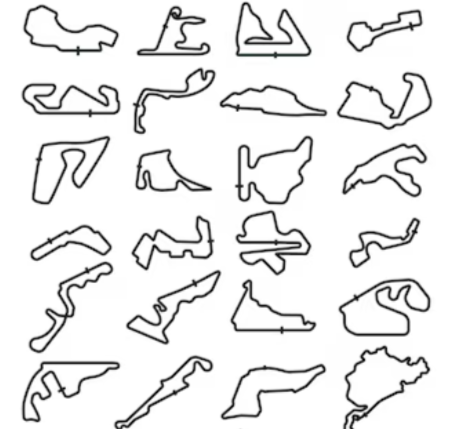

In [ ]:
tracks = circuits.merge(races, left_on='circuitid',right_on='circuitId',how = 'inner') 
tracks = tracks.merge(results,on = 'raceId',how = 'left')
tracks = tracks[['name_x','circuitid','driverId','position','grid','raceId','year']]
tracks.rename(columns={'name_x':'circuit'},inplace=True)
tracks.dropna(inplace = True)


tracks = tracks.loc[(tracks['year'] >= '2010-01-01')]
tracks   #adjust according to your view prespective by writing tracks.head(any num)